# Fine-Tuning Llama 2 on a existing Dataset

This tutorial will walk you through how to fine-tune the new Llama-2 on Mathematical Data to build your own model. 

We will talk about the methods involved.

## Step 1: Installation of Dependencies

We will be training on Google Collab. (Windows specific instructions are highlighted. For further details check `getting-started/init.pynb`)

In [ ]:
# Run once on a new Colab instance to install the required packages.
!pip install -U bitsandbytes
# For Windows:
# !pip install bitsandbytes==<version> --prefer-binary --extra-index-url=https://jllllll.github.io/bitsandbytes-windows-webui 
!pip install -U git+https://github.com/huggingface/transformers.git
!pip install -U git+https://github.com/huggingface/peft.git
!pip install -U git+https://github.com/huggingface/accelerate.git
!pip install -U datasets scipy ipywidgets einops

## Step 2: GPU setup

We can actually use the train function provided by Huggingface, but using accelerator allows us the flexibility of performing distributed computing. 

FullyShardedDataParallel allows us to load large models onto multiple GPUs by sharding.

You can read more here: https://huggingface.co/docs/accelerate/usage_guides/fsdp

In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

To track our metrics we are using Tensorboard. 

In [ ]:
# Tensorboard

!pip install tensorboard
%load_ext tensorboard

## Step 3: Load Dataset

We will be working with the MetaMathQA dataset today. This allows us to train our own math answering LLM.

To keep things simple. Let's just use the dataset as a whole.

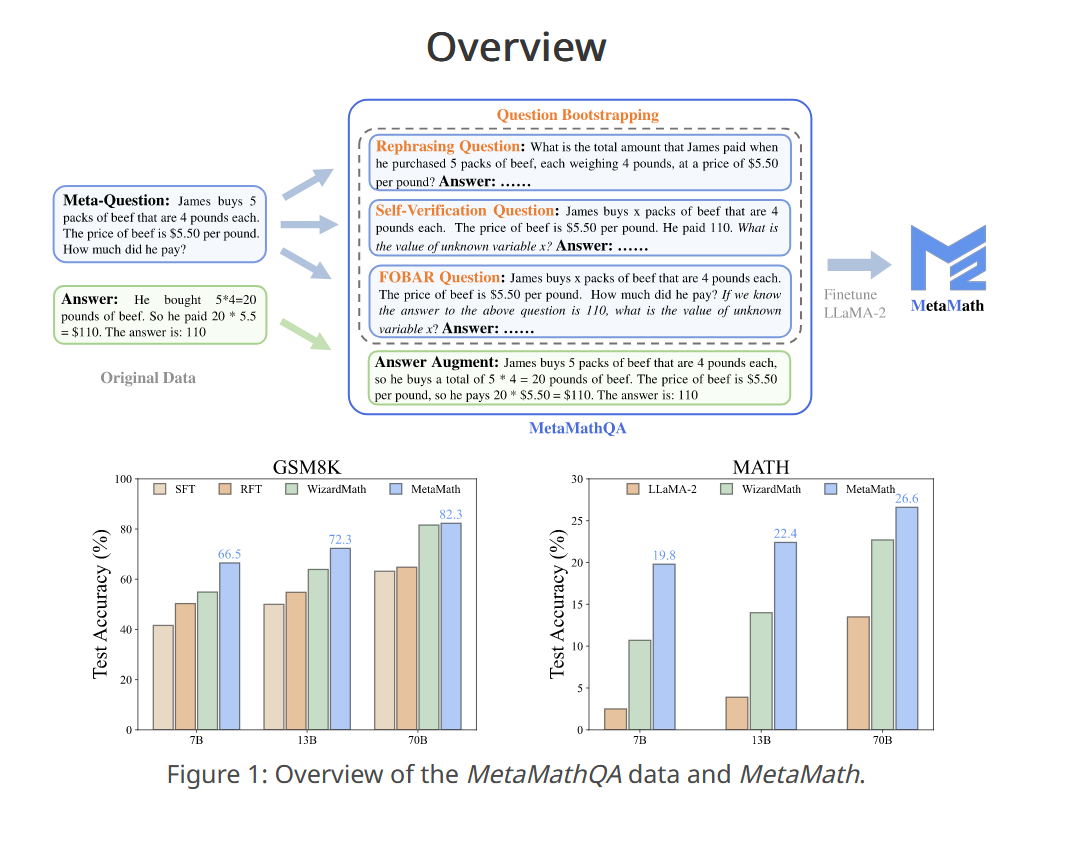

In [ ]:
from datasets import load_dataset

dataset_id = 'meta-math/MetaMathQA'

train_dataset = load_dataset(dataset_id, split='train[:70%]')
eval_dataset = load_dataset(dataset_id, split='train[70%:90%]')
test_dataset = load_dataset(dataset_id, split='train[90%:]')

len(train_dataset), len(eval_dataset), len(test_dataset)

In [ ]:
data_point = train_dataset[:1]

## Step 4: Load up Model

We are loading up the model with the 8 bit quantization (if you want to run it on a more lighter machine you can use 4 bit quantization as well). The BitsAndBytes handles the quantization.

Lower quantization would result in loss of information but makes it easier on weaker GPUs

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling

base_model_id = "NousResearch/Llama-2-7b-chat-hf"
model = AutoModelForCausalLM.from_pretrained(base_model_id, 
                                             load_in_8bit=True, 
                                             torch_dtype=torch.float16, 
                                             trust_remote_code=True)

## Step 5: Dataset Processing

We want to set max_length, which affects your model compute each cycle. 

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_eos_token=True,
    add_bos_token=True, 
)

In [ ]:
def tokenize(prompt):
    result = tokenizer(prompt)
    result["labels"] = result["input_ids"].copy()
    return result

Now let's convert each sample with the suggested prompt

In [ ]:
def generate_and_tokenize_prompt(data_point):
    full_prompt =f'''"Below is an instruction that describes a task. " "Write a response that appropriately completes the request.\n\n" "### Instruction:\n{data_point.instruction}\n\n### Response: Let's think step by step."'''
    return tokenize(full_prompt)

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Double Checking the text to see how it is

In [ ]:
untokenized_text = tokenizer.decode(tokenized_train_dataset[1]['input_ids']) 
print(untokenized_text)

Now let us define the max_length. 

In [ ]:
max_length = 256 

We are truncating the inputs to max_length and for smaller inputs we are padding them to the max_length.

In [ ]:

# redefine the tokenize function and tokenizer

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
    trust_remote_code=True,
)
tokenizer.pad_token = tokenizer.eos_token

# Here we are truncating the inputs to max_length and for smaller inputs we are padding them to the max_length
def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True, 
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy() # needed for FSDP
    return result

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

## Step 6: Setup LoRA

`r` defines the rank of decomposition, which controls the parameters trained. If you use a larger r, you will train more layers. But since the models are large, this means it is heavier to trian. 

`alpha` scales the learned weights wrt to the original weights. A higher alpha would prefer the weights that you have finetuned.

You can learn more here: https://medium.com/@manyi.yim/more-about-loraconfig-from-peft-581cf54643db

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "Wqkv",
        "fc1",
        "fc2",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

## Training

First as always, run the model for 5 steps and see that nothing breaks. 

Then you can run it for 500 steps and see when overfitting is occuring. Correspondingly, use the appropriate checkpoint that is generated.

In [ ]:
import transformers
from datetime import datetime

project = "math-finetune"
base_model_name = "llama"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=5,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        max_steps=1000,
        learning_rate=2.5e-5, 
        logging_steps=25,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to=['tensorboard'],
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

## Test your model

The PEFT library only saves the QLoRA adapters, so first you need to load the base model and then load the adapters. 

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "microsoft/phi-2"

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    load_in_8bit=True,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.float16,
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
    use_fast=False,
)

In [ ]:
from peft import PeftModel

peft_model = PeftModel.from_pretrained(base_model, "llama-math-finetune/checkpoint-500")

Now load up the eval_prompt and ask it a question on the dataset!

In [ ]:
eval_prompt = '''"Below is an instruction that describes a task. " 
"Write a response that appropriately completes the request." 

"### Instruction:

Gracie and Joe are choosing numbers on the complex plane. Joe chooses the point $1+2i$. Gracie chooses $-1+i$. How far apart are Gracie and Joe's points?


### Response: Let's think step by step."'''


model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

peft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(peft_model.generate(**model_input, max_new_tokens=100)[0], skip_special_tokens=True))

## Further Resources

1. []()